# Imports

In [709]:
import cv2
import numpy as np
import skimage.segmentation
from matplotlib import pyplot as plt
from skimage import util as ski

# Helper Function

In [710]:
def display_img(img, title=""):
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load Image

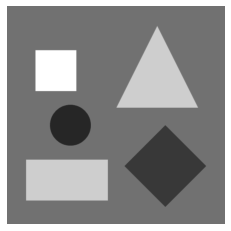

In [711]:
SEG1 = cv2.imread("SEG1.png")
SEG1 = cv2.cvtColor(SEG1, cv2.COLOR_RGB2GRAY)
display_img(SEG1)

# Apply Gaussian Noise

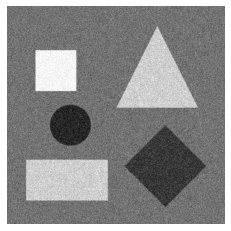

In [733]:
GAUSSIAN_NOISE_STD = 0.1
SEG2 = 255 * ski.random_noise(SEG1, mode="gaussian", var=GAUSSIAN_NOISE_STD**2)
cv2.imwrite("SEG2.png", SEG2)
display_img(SEG2)

# Apply Random Impulse Noise

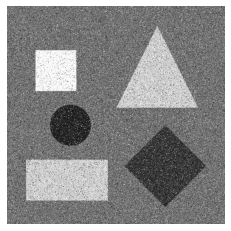

In [734]:
SEG3 = 255 * ski.random_noise(SEG2/255, mode="s&p")
cv2.imwrite("SEG3.png", SEG3)
display_img(SEG3)

# Generate Test Images

In [714]:
IMPULSE_NOISE_AMT_1 = 0.025
IMPULSE_NOISE_AMT_2 = 0.05
IMPULSE_NOISE_AMT_3 = 0.1

In [715]:
GAUSSIAN_STD_A = 0.1
IMG_A = 255 * ski.random_noise(SEG1, mode="gaussian", var=GAUSSIAN_STD_A**2)

IMG_A1 = 255 * ski.random_noise(IMG_A/255, mode="s&p", amount=IMPULSE_NOISE_AMT_1)
IMG_A2 = 255 * ski.random_noise(IMG_A/255, mode="s&p", amount=IMPULSE_NOISE_AMT_2)
IMG_A3 = 255 * ski.random_noise(IMG_A/255, mode="s&p", amount=IMPULSE_NOISE_AMT_3)

SET_A = [IMG_A1, IMG_A2, IMG_A3]

In [716]:
GAUSSIAN_STD_B = 0.25
IMG_B = 255 * ski.random_noise(SEG1, mode='gaussian', var=GAUSSIAN_STD_B**2)

IMG_B1 = 255 * ski.random_noise(IMG_B/255, mode="s&p", amount=IMPULSE_NOISE_AMT_1)
IMG_B2 = 255 * ski.random_noise(IMG_B/255, mode="s&p", amount=IMPULSE_NOISE_AMT_2)
IMG_B3 = 255 * ski.random_noise(IMG_B/255, mode="s&p", amount=IMPULSE_NOISE_AMT_3)

SET_B = [IMG_B1, IMG_B2, IMG_B3]

In [717]:
GAUSSIAN_STD_C = 0.5
IMG_C = 255 * ski.random_noise(SEG1, mode='gaussian', var=GAUSSIAN_STD_C**2)

IMG_C1 = 255 * ski.random_noise(IMG_C/255, mode="s&p", amount=IMPULSE_NOISE_AMT_1)
IMG_C2 = 255 * ski.random_noise(IMG_C/255, mode="s&p", amount=IMPULSE_NOISE_AMT_2)
IMG_C3 = 255 * ski.random_noise(IMG_C/255, mode="s&p", amount=IMPULSE_NOISE_AMT_3)

SET_C = [IMG_C1, IMG_C2, IMG_C3]

In [718]:
ALL_IMG = SET_A + SET_B + SET_C

# Basic Thresholding
## Base Image
Counting the number of 255 intensity pixels gives us the sum of actual area of the shapes

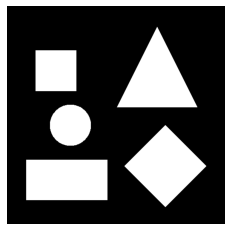

In [719]:
BASE_THRESH_IMG = np.copy(SEG1)
BASE_THRESH_IMG[BASE_THRESH_IMG < 100]  = 0
BASE_THRESH_IMG[BASE_THRESH_IMG > 200] = 0
BASE_THRESH_IMG[BASE_THRESH_IMG == 0] = 255
BASE_THRESH_IMG[BASE_THRESH_IMG < 200] = 0
display_img(BASE_THRESH_IMG)
ACTUAL_AREA = cv2.countNonZero(BASE_THRESH_IMG)

## Threshold Images
We apply a binary thresholding to each image, and approximate the area of labelled shapes as the area of pixels with a intensity of 255. We compare back to the base image, which perfectly highlights the shapes.

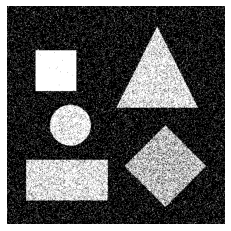

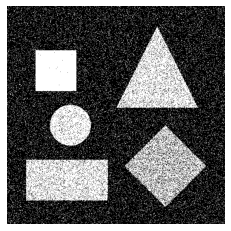

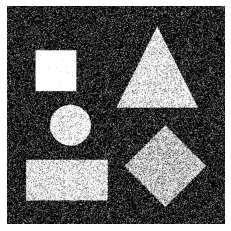

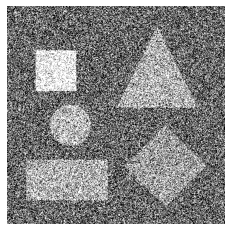

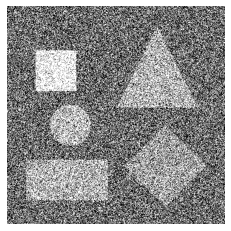

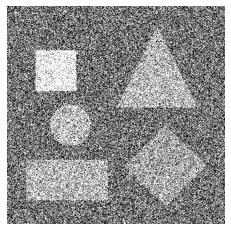

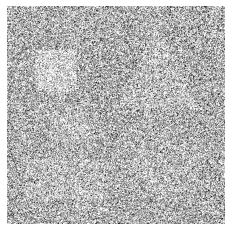

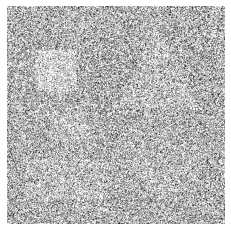

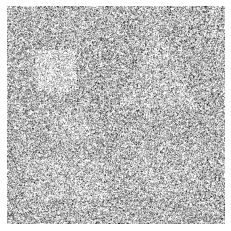

In [720]:
thresholded_set = []
relative_error = []
for img in ALL_IMG:
    copy = np.copy(img)
    copy[copy > 180] = 1
    copy[copy < 70] = 1
    copy[copy == 1] = 255
    copy[copy < 255] = 0
    thresholded_set.append(copy)
    relative_error.append(100 * (ACTUAL_AREA - cv2.countNonZero(copy))/ACTUAL_AREA)
    display_img(copy)

## Labeling Error for Binary Threshold Images

In [721]:
labeling_error = []
for img in thresholded_set:
    count = 0
    for i in range(len(img)):
        for j in range(len(img[0])):
            if BASE_THRESH_IMG[i][j] == 255 and img[i][j] == 0:
                count += 1
    labeling_error.append(100 * count / ACTUAL_AREA)
labeling_error

[16.332973215663717,
 15.944326743647665,
 15.04917710774066,
 30.377562330756387,
 29.73075358130007,
 28.062520168927925,
 26.4602303817715,
 25.852707196273485,
 24.459472731609445]

# Chan-Vese

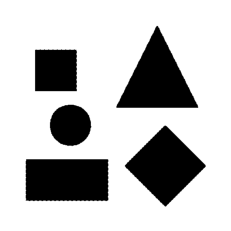

In [732]:
copy = np.copy(SEG1)
ret = 255 * skimage.segmentation.chan_vese(copy, mu=0.05, lambda1=3, lambda2=1, dt=0.05)
display_img(ret)

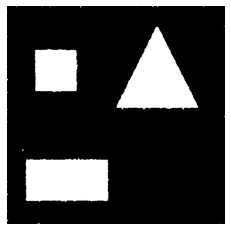

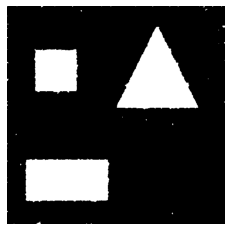

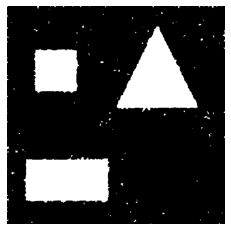

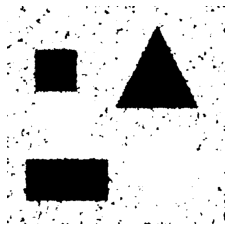

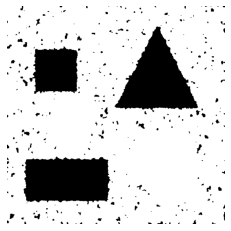

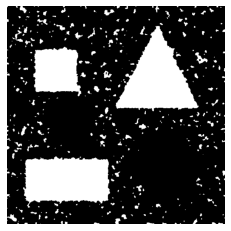

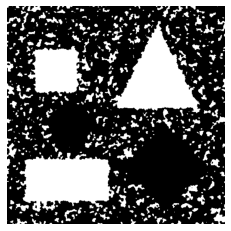

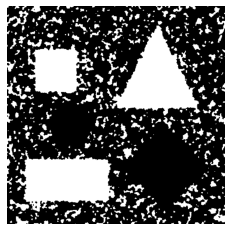

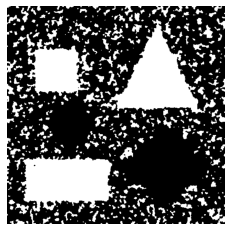

In [722]:
chan_vese_set = []
cv_relative_error = []
for img in ALL_IMG:
    copy = np.copy(img)
    copy = 255 * skimage.segmentation.chan_vese(copy, mu=0.3, lambda1=1, lambda2=1, dt=0.1)
    chan_vese_set.append(copy)
    cv_relative_error.append(100 * (ACTUAL_AREA - cv2.countNonZero(copy))/ACTUAL_AREA)
    display_img(copy)

## Labeling Error for Chan-Vese Segmentation

In [723]:
labeling_error_cv = []
for img in chan_vese_set:
    count = 0
    for i in range(len(img)):
        for j in range(len(img[0])):
            if BASE_THRESH_IMG[i][j] == 255 and img[i][j] == 0:
                count += 1
    labeling_error_cv.append(100 * count / ACTUAL_AREA)
labeling_error_cv

[36.4205239010565,
 36.423330012767806,
 36.419120845200844,
 63.580879154799156,
 63.580879154799156,
 36.4205239010565,
 36.419120845200844,
 36.433151403757385,
 36.46401863258176]

# Method Comparison
Chan-Vese Segmentation is far more effective at filtering the objects we desire as compared to basic thresholding, especially when there is a large amount of Gaussian and impulse noise on the image. Chan-Vese was however unable to find the objects shaded darker than the background, and could only find those lighter than the background with these parameters. I was unable to find parameters that would get all of the objects, the parameters that could find the darker objects were poor at doing so.

# Hough Transform

The Hough Transform is used to detect lines in images. Lines can be described in slope-intercept form by $y=mx+b$. To avoid the issue of vertical lines giving undefined slopes, we can express lines in a polar form as $r = x \cos\theta + y \sin{\theta}$. For each of the edge points detected, we can vary the $\theta$ values, and calculate the corresponding $r$ value for each line. Plotting this on a $r$, $\theta$ plane, all of the lines that go through one point can be visualized as a sinusoidal curve. Using multiple points will create more sinusoidal curves which will intersect each other at certain $(r, \theta)$ points that define the line in our image.

The Hough Transform is effective at connected disconnected edges, and is insensitive to noise.
The Hough Transform is inefficient at greater dimensions, as its' time complexity is $O(n^4)$.

# Linear Heat Equation

In [729]:
HEART = cv2.imread("heart.jpg")
HEART = cv2.cvtColor(HEART, cv2.COLOR_RGB2GRAY)

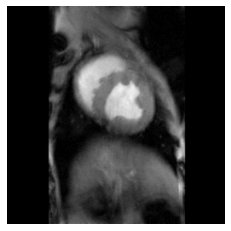

In [728]:
A = np.copy(HEART)

DT = 0.1
n = 10
for l in range(n):
    for i in range(1, len(HEART)-1):
        for j in range(1, len(HEART[0])-1):
            x_partial = (A[i+1][j] - 2*A[i][j] + A[i-1][j]) / 4
            y_partial = (A[i][j+1] - 2*A[i][j] + A[i][j-1]) / 4
            laplacian = x_partial + y_partial
            A[i][j] += DT * laplacian
display_img(A)

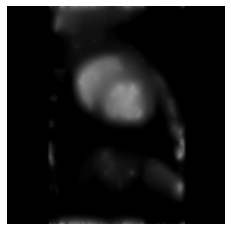

In [730]:
B = np.copy(HEART)

DT = 0.1
n = 100
for l in range(n):
    for i in range(1, len(HEART)-1):
        for j in range(1, len(HEART[0])-1):
            x_partial = (B[i+1][j] - 2*B[i][j] + B[i-1][j]) / 4
            y_partial = (B[i][j+1] - 2*B[i][j] + B[i][j-1]) / 4
            laplacian = x_partial + y_partial
            B[i][j] += DT * laplacian
display_img(B)

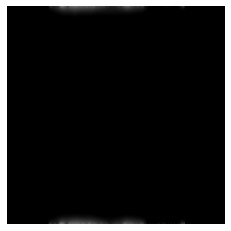

In [731]:
C = np.copy(HEART)

DT = 0.1
n = 1000
for l in range(n):
    for i in range(1, len(HEART)-1):
        for j in range(1, len(HEART[0])-1):
            x_partial = (C[i+1][j] - 2*C[i][j] + C[i-1][j]) / 4
            y_partial = (C[i][j+1] - 2*C[i][j] + C[i][j-1]) / 4
            laplacian = x_partial + y_partial
            C[i][j] += DT * laplacian
display_img(C)